# SKY MAP PLOT
The distribution of the eRO-ExTra sources in the Western galaxtic hemisphere.

The point scale represents the source brightness normalised by flux.

The sources are color-coded by:
- lightcurve class (dark blue = decline, light blue = flare, red = brightening, orange = other)
- spectral properties (Gamma), color-coded by spectral shape, from soft (orange) to hard (purple)

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord, ICRS, Galactic, FK4, FK5
import astropy.units as u

from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings('ignore')

from custom_colormaps import custom_cmap_gamma
from plot_style import set_plot_style

set_plot_style()

In [43]:
#load the eRO-ExTra catalog
#nt_cat = 'data/eroextra2006_excl.fits'
nt_cat = 'data/catalog/eroextra_final.fits'
df_nt = Table.read(nt_cat, format='fits') 
names_nt = [name for name in df_nt.colnames if len(df_nt[name].shape) <= 1]
df_nt = df_nt[names_nt].to_pandas()

source_names_nt = df_nt['ERO_NAME'].str.decode('utf-8')

xarr_nt = df_nt['ERO_RA'] #coordinates:RA
yarr_nt = df_nt['ERO_DEC'] #coordinates:Dec

lctype = df_nt['ERO_LCCLASS'] #lightcurve class
gamma_nt = df_nt['ERO_GAMMA'] #photon index

#South ecliptic pole coordinates
sep_x = 90.0000 
sep_y = -66.5500

# Convert coordinates to Galactic system
coord_nt = SkyCoord(xarr_nt, yarr_nt, frame='icrs', unit=u.deg)
gal_nt = coord_nt.galactic

coord_sep = SkyCoord(sep_x, sep_y, frame='icrs', unit=u.deg)
gal_sep = coord_sep.galactic

flux_units = df_nt['ERO_FLUX_MOD']

#size of points normalised by model flux
flux = (((np.log10(df_nt['ERO_FLUX_MOD'])+15))**5)/3
flux14 = ((np.log10(1e-14)+15)**5)/4
flux13 = ((np.log10(1e-13)+15)**5)/4
flux12 = ((np.log10(1e-12)+15)**5)/4

In [13]:
#set colors according to lightcurve types
colors_nt = ['k' for i in range(len(lctype))]
for i, row in df_nt.iterrows():
    #colors_nt[i] = 'k'
    if row['ERO_LCCLASS']==1: #blue
        colors_nt[i] = '#0571b0'
    if row['ERO_LCCLASS']==3: #red
        colors_nt[i] = '#ca0020'
    if row['ERO_LCCLASS']==4: #orange
        colors_nt[i] = '#f4a582'
    if row['ERO_LCCLASS']==2: #light blue
        colors_nt[i] = '#92c5de'

In [55]:
def plot_skymap_lcclass_clickable(gal_l, gal_b, colors, flux, flux_units, flux12, flux13, source_names, gamma, ra, dec, image_dir='data/galaxy_ls10_images'):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection="aitoff")

    lon_rad = -gal_l.wrap_at('180d').radian
    lat_rad = gal_b.radian

    sc = ax.scatter(lon_rad, lat_rad, color=colors, s=flux, edgecolors='black', linewidths=0.5, picker=5)

    ax.grid(True, linestyle='--', linewidth=0.5, color='k')
    plt.xticks(
        ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
        labels=[''] * 11
    )
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.yticks(
        ticks=np.radians([75, 60, 45, 30, 15, 0, -15, -30, -45, -60, -75]),
        labels=[''] * 11
    )

    # Dummy points for legend
    ax.scatter([], [], color='white', edgecolor='k', s=flux13, label='1e-13')
    ax.scatter([], [], color='white', edgecolor='k', s=flux12, label='1e-12')

    ax.legend(
        loc='upper right',
        fontsize=9,
        title='flux, erg cm$^{-2}$ s$^{-1}$',
        bbox_to_anchor=(1.0, 1.08)
    )

    # Annotation box setup at fixed display coords (right-top corner in data coords)
    annot = ax.annotate(
        "",
        xy=(0, 0),  # arrow target (will be set dynamically)
        xytext=(-2.5, 0.2),  # fixed box position in data coordinates
        textcoords="data",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
        fontsize=9
    )
    annot.set_visible(False)

    def on_pick(event):
        ind = event.ind[0]
        pos = sc.get_offsets()[ind]

        lon = gal_l[ind].deg
        lat = gal_b[ind].deg
        g = gamma[ind]
        f = flux[ind]

        text = (f"Source name: {source_names[ind]}\n"
                #f"Galactic lon: {lon:.2f}°\n"
                #f"Galactic lat: {lat:.2f}°\n"
                f"RA: {ra[ind]:.2f}°\n"
                f"Dec: {dec[ind]:.2f}°\n"
                f"Gamma index: {g:.2f}\n"
                #f"Flux: {f:.2e}"
                f"Flux: {flux_units[ind]:.2e} erg cm$^{{-2}}$ s$^{{-1}}$")

        annot.xy = pos  # arrow target
        annot.set_text(text)
        annot.set_visible(True)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('pick_event', on_pick)
    plt.tight_layout()
    plt.show()


<IPython.core.display.Javascript object>


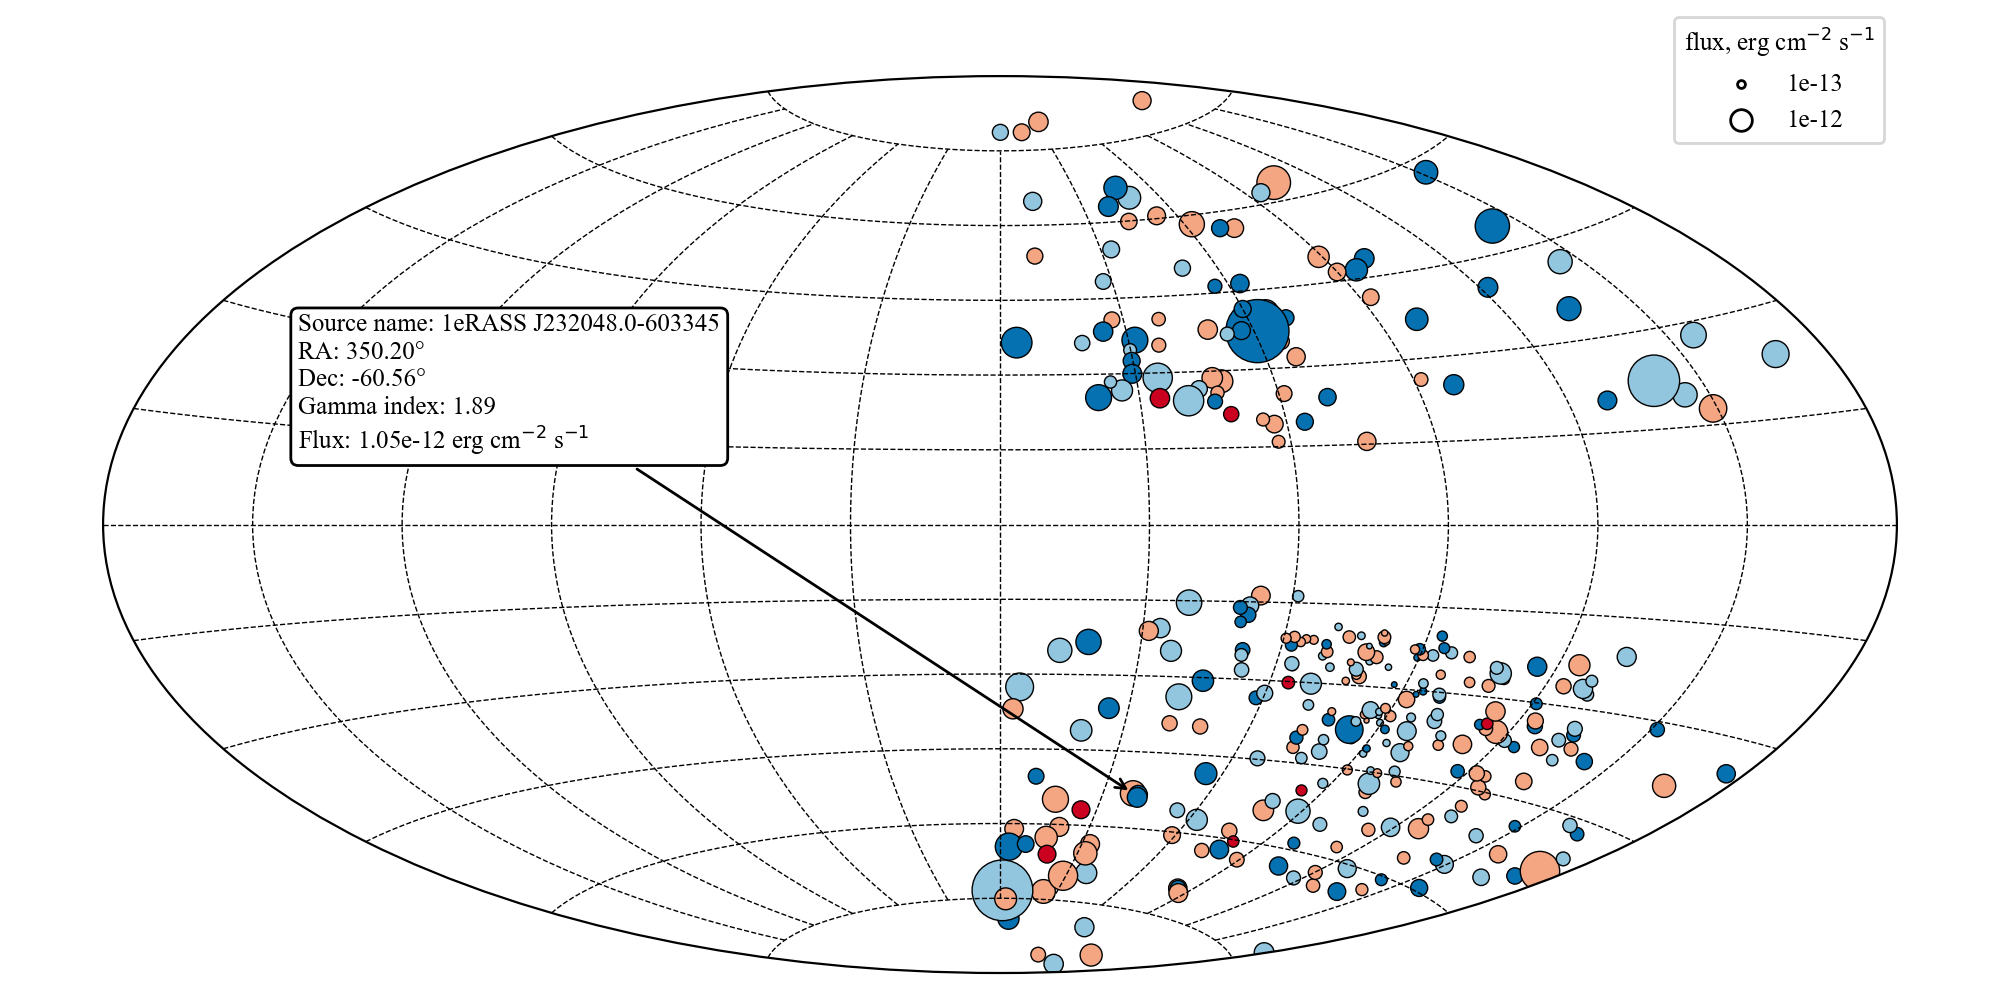

In [56]:
plot_skymap_lcclass_clickable(
    gal_l=gal_nt.l,
    gal_b=gal_nt.b,
    colors=colors_nt,
    flux=flux,
    flux_units= flux_units,
    flux12=flux12,
    flux13=flux13,
    source_names=source_names_nt,
    gamma=gamma_nt,
    ra = xarr_nt,
    dec = yarr_nt,
    image_dir='data/galaxy_ls10_images'
)

In [37]:
#Skymap colorcoded by photon index

def plot_skymap_gamma(gal_l, gal_b, gamma, flux, cmap):
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection="aitoff")

    sc = ax.scatter(-gal_l.wrap_at('180d').radian, gal_b.radian, c=gamma, s=flux, cmap=cmap, edgecolors='black',linewidths=0.5)

    ax.grid(True, linestyle='--', linewidth=0.5, color='k')

    plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0,
                                 30, 60, 90, 120, 150]),
               labels=[''] * 11)

    plt.yticks(ticks=np.radians([75, 60, 45, 30, 15, 0,
                                 -15, -30, -45, -60, -75]),
               labels=[''] * 11)

    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)

    cbar = plt.colorbar(sc, shrink=0.6)
    cbar.set_label('$\Gamma$', rotation=0, labelpad=9)
    cbar.ax.yaxis.set_label_coords(2.5, 1.1)

    plt.tight_layout()
    plt.show()

In [46]:
#plot_skymap_gamma(gal_l=gal_nt.l, gal_b=gal_nt.b, gamma=gamma_nt,flux=flux, cmap=custom_cmap_gamma)

<IPython.core.display.Javascript object>


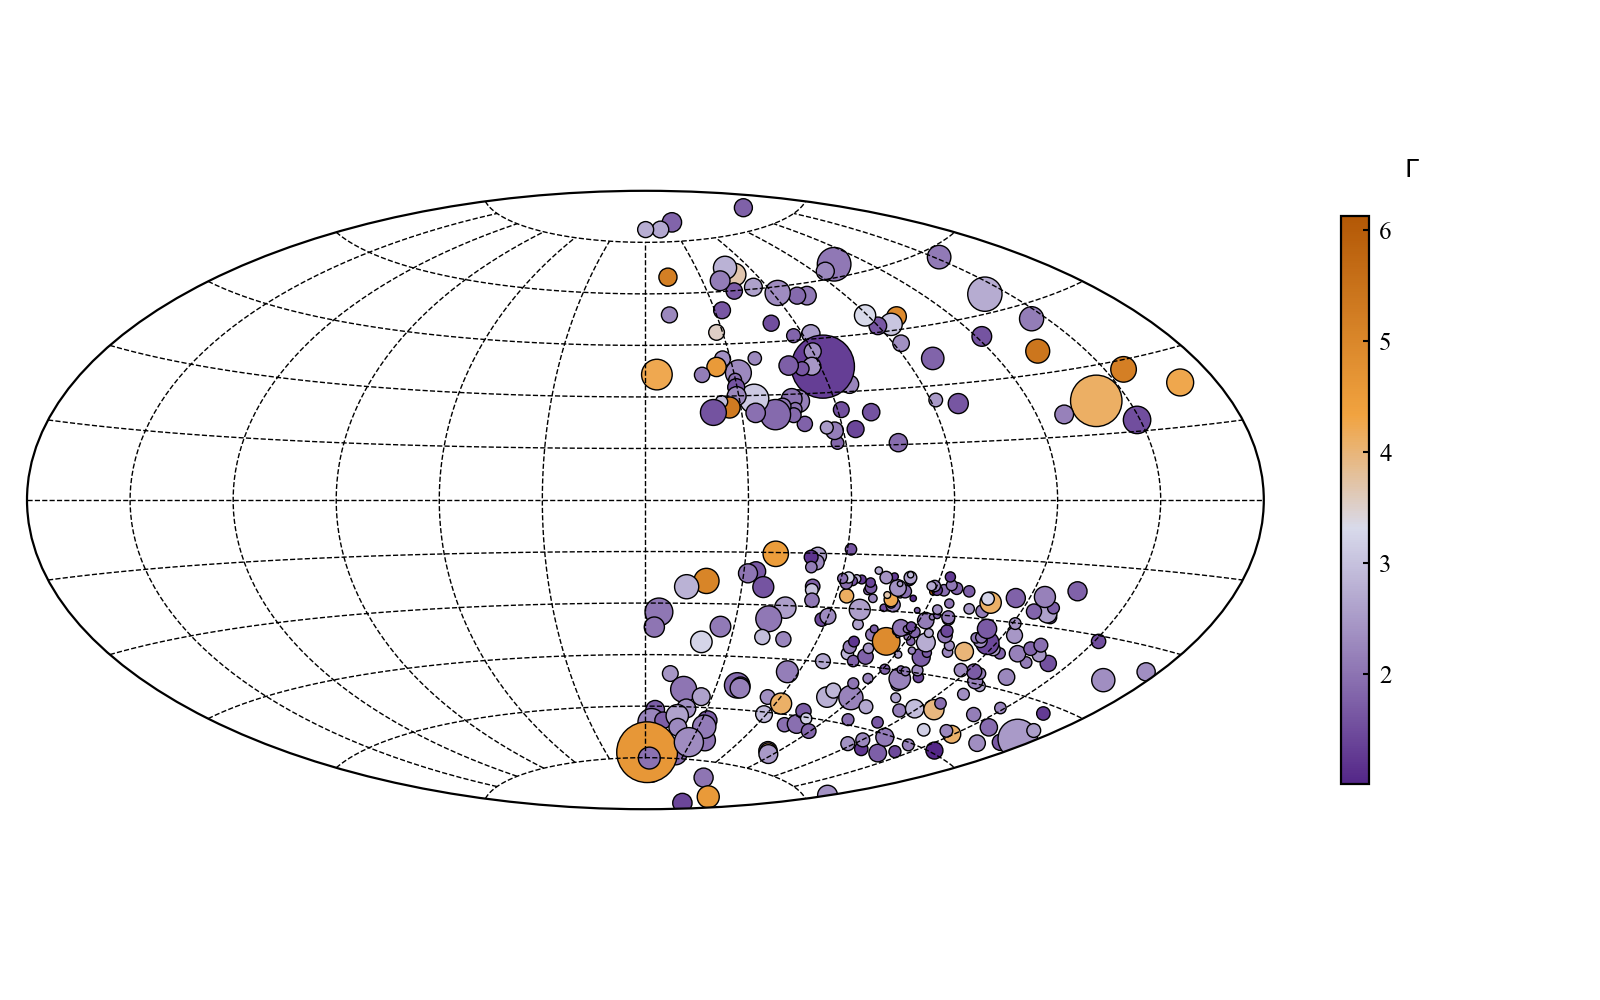

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Gamma >', max=6.12611672085…

<function __main__.interactive_skymap(gamma_min=1.0)>

In [11]:
#Add a slider for visualisation of different subsets of Gamma
import ipywidgets as widgets
from IPython.display import display

def interactive_skymap(gamma_min=1.0):
    mask = gamma_nt > gamma_min
    plot_skymap_gamma(
        gal_l=gal_nt.l[mask],
        gal_b=gal_nt.b[mask],
        gamma=gamma_nt[mask],
        flux=flux[mask],
        cmap=custom_cmap_gamma
    )

widgets.interact(
    interactive_skymap,
    gamma_min=widgets.FloatSlider(
        value=1.0,
        min=np.min(gamma_nt),
        max=np.max(gamma_nt),
        step=0.05,
        description='Gamma >',
        continuous_update=False
    )
)